In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

## Tokenizer

In [17]:
from tokenizers import decoders, models, normalizers, pre_tokenizers, processors, trainers, Tokenizer

tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]", "[HYP]", "[GOAL]", "[TACTIC]"]
trainer = trainers.WordPieceTrainer(vocab_size=200, special_tokens=special_tokens)

In [18]:
files = ['../dataset/unroll.v']

def dataset_iterator():
    for path in files:
        with open(path, "r") as f:
            for line in f:
                yield line

tokenizer.train_from_iterator(dataset_iterator(), trainer=trainer)

In [19]:
from transformers import GPT2TokenizerFast

tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
tokenizer.decoder = decoders.ByteLevel()

new_tokenizer = GPT2TokenizerFast(tokenizer_object=tokenizer)
new_tokenizer.save_pretrained('unroll-tokenizer')

('unroll-tokenizer/tokenizer_config.json',
 'unroll-tokenizer/special_tokens_map.json',
 'unroll-tokenizer/vocab.txt',
 'unroll-tokenizer/added_tokens.json',
 'unroll-tokenizer/tokenizer.json')

## Theorem analysis

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('unroll-tokenizer')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right'

tactic_token = tokenizer.convert_tokens_to_ids('[TACTIC]')

In [66]:
files = ['../dataset/unroll.v']
steps = []

for file in files:
    data = open(file, 'r').read()
    for th in data.split('[THEOREM]')[1:]:
        steps.append([])
        for step in th.split('[HYP]')[1:]:
            steps[-1].append('[HYP]' + step)

print('Collected {0} theorems and {1} steps'.format(len(steps), sum(len(x) for x in steps)))
print(steps[-1][-1])

Collected 548369 theorems and 7688801 steps
[HYP]
HCM: C -> M
HCYMY: (C -> Y) -> M -> Y
HMY: M -> Y
HY: Y
HYVM: (Y -> V) -> M
HZ: Z
HZYV: (Z -> Y) -> V
[GOAL]
Y
[TACTIC]
apply HY. 



In [67]:
tokens = [[tokenizer.encode(step) for step in th] for th in steps]
print('Total tokens {0}'.format(sum(len(tok) for th in tokens for tok in th)))

Total tokens 586244317


In [71]:
tokens[0]

[[5, 53, 6, 53, 35, 94, 129, 53, 7, 53, 120, 172, 11, 104],
 [5, 53, 150, 13, 129, 53, 6, 53, 35, 53, 7, 53, 111, 172, 11, 104]]

In [35]:
part_to_id = {}
for tok in ["[HYP]", "[GOAL]", "[TACTIC]"]:
    part_to_id[tok] = tokenizer.convert_tokens_to_ids(tok)
    print(tok, part_to_id[tok])

[HYP] 5
[GOAL] 6
[TACTIC] 7


In [69]:
pickle.dump(tokens, open('unroll-tokens', 'wb'))

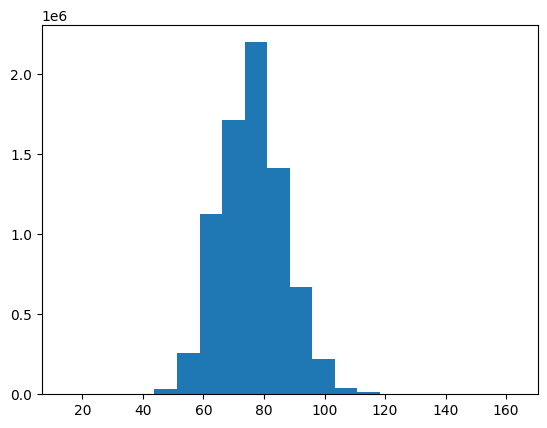

In [70]:
plt.hist([len(tok) for th in tokens for tok in th], bins=20)
plt.show()

## Dataset

In [72]:
init_repeat = 1
repeat = 1

indices = np.arange(len(tokens) // init_repeat)
np.random.shuffle(indices)
pickle.dump(indices, open('unroll-test-split', 'wb'))

In [73]:
from datasets import Dataset, DatasetDict

max_tokens = 128
test_size = 0.01

split = int(len(indices) * test_size)
test_indices, train_indices = indices[:split], indices[split:]
test_tok = [step for j in test_indices for step in tokens[init_repeat * j]]
train_tok = [step for i in range(repeat) for j in train_indices for step in tokens[init_repeat * j + i]]
test_data = Dataset.from_dict({'input_ids': [tok for tok in test_tok if len(tok) <= max_tokens]})
train_data = Dataset.from_dict({'input_ids': [tok for tok in train_tok if len(tok) <= max_tokens]})

dataset = DatasetDict({'train': train_data, 'test': test_data})

In [4]:
from transformers import GPT2Config, GPT2LMHeadModel

max_tokens = 128
config = GPT2Config(vocab_size=len(tokenizer), n_positions=max_tokens, n_embd=128, n_layer=8, n_head=8, 
                    bos_token_id=tokenizer.eos_token_id, eos_token_id=tokenizer.eos_token_id)
model = GPT2LMHeadModel(config).cuda()
print('Total parameters {0}'.format(sum(p.numel() for p in model.parameters())))

Total parameters 1628544


In [80]:
def generate_loss_mask(sample, tactic_token):
    tactic_pos = sample['input_ids'].index(tactic_token)
    mask = [0] * (tactic_pos + 1) + [1] * (len(sample['input_ids']) - (tactic_pos + 1))
    sample['loss_mask'] = mask
    return sample

tactic_token = tokenizer.convert_tokens_to_ids('[TACTIC]')
dataset = dataset.map(lambda x: generate_loss_mask(x, tactic_token))

Map:   0%|          | 0/7611052 [00:00<?, ? examples/s]

Map:   0%|          | 0/77256 [00:00<?, ? examples/s]

In [82]:
dataset.save_to_disk('unroll.hf')

Saving the dataset (0/15 shards):   0%|          | 0/7611052 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/77256 [00:00<?, ? examples/s]

In [3]:
from datasets import load_from_disk

dataset = load_from_disk('unroll.hf')

In [18]:
import torch
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

epoch_num = 2
batch_size = 64
max_steps = (epoch_num * len(dataset['train'])) // batch_size

class DataCollatorWithLossMask(DataCollatorForLanguageModeling):
    def __call__(self, features):
        batch = super().__call__(features)
        tactic_pos = torch.argmax((batch['input_ids'] == tactic_token).long(), dim=1)[:, None]
        indices = torch.arange(batch['input_ids'].shape[1])
        batch['loss_mask'] = (indices > tactic_pos) & batch['attention_mask']
        return batch

collator = DataCollatorWithLossMask(tokenizer=tokenizer, mlm=False, pad_to_multiple_of=8)

training_args = TrainingArguments(
    output_dir="./unroll-output-repeat-1-small",
    max_steps=max_steps,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=64,
    eval_strategy="steps",
    save_steps=10000,
    eval_steps=10000,
    learning_rate=5e-4,
    weight_decay=0.01,
    lr_scheduler_type='cosine',
    warmup_steps=3000,
    logging_dir='./augapply-logs',
    report_to='none'
)

class TrainerWithLossMask(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model.forward(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        lm_logits = outputs['logits']
        labels = inputs['labels']
        
        shift_logits = lm_logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        
        loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        
        mask = inputs['loss_mask'][..., 1:].contiguous().view(-1)
        loss = torch.sum(mask * loss) / torch.sum(mask)
        
        return (loss, outputs) if return_outputs else loss

trainer = TrainerWithLossMask(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=collator,
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
max_steps is given, it will override any value given in num_train_epochs


In [19]:
trainer.train()

Step,Training Loss,Validation Loss
10000,0.258700,0.192959
20000,0.082900,0.051146
30000,0.059100,0.043046
40000,0.049000,0.037699
50000,0.046400,0.033701
60000,0.042100,0.033097
70000,0.038200,0.032379
80000,0.036100,0.030842
90000,0.035800,0.029506
100000,0.033400,0.028108


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



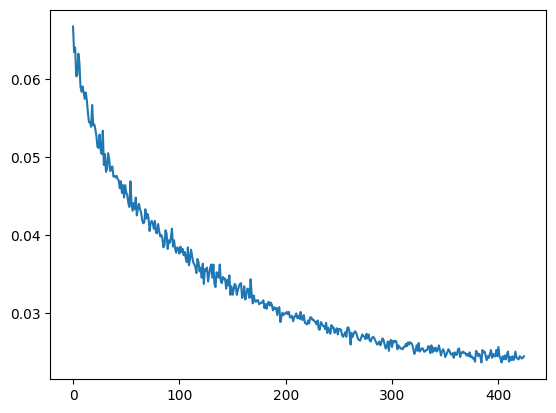

In [24]:
plt.plot([x['loss'] for x in trainer.state.log_history if 'loss' in x][50:])
plt.show()

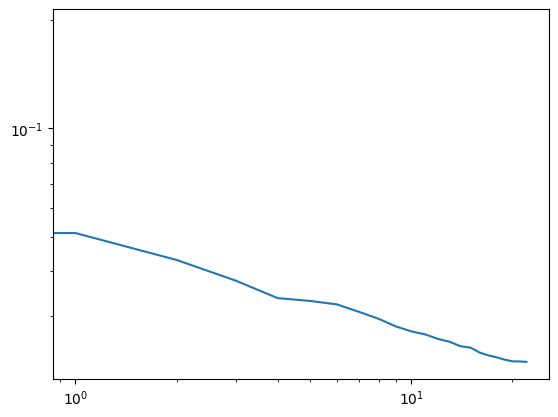

In [23]:
plt.loglog([x['eval_loss'] for x in trainer.state.log_history if 'eval_loss' in x])
plt.show()

In [18]:
model = GPT2LMHeadModel.from_pretrained('unroll-output-repeat-1-small/checkpoint-230000').cuda()
_ = model.eval()

## Generation

In [9]:
from tiny_theorems import Env

def pretty(string):
    return ''.join(string.split('##'))

def extract_statement(state):
    hyp, goal = state.split('[GOAL]')
    hyp = hyp.split('[HYP]')[1].strip()
    if not hyp:
        return goal.split('[TACTIC]')[0].strip()
    return None

def extract_tactic(state):
    _, tactic = state.split('[TACTIC]')
    return tactic.strip()

hyp_token = tokenizer.convert_tokens_to_ids('[HYP]')
goal_token = tokenizer.convert_tokens_to_ids('[GOAL]')
newline_token = tokenizer.encode('\n')[0]
dot_token = tokenizer.convert_tokens_to_ids('.')

def detect_statement(tok):
    return tok[:3] == [hyp_token, newline_token, goal_token]

In [11]:
statement_tokens = [x for x in dataset['test']['input_ids'] if detect_statement(x)]
statements = [pretty(x) for x in tokenizer.batch_decode(statement_tokens)]

In [33]:
counter = 0
step_list = []

for i, orig_state in enumerate(statements[:1000]):
    if i % 25 == 0:
        print(i)
    step_list.append([])
    env = Env(extract_statement(orig_state))

    try:
        for _ in range(250):
            state = env.current_state()
            if state is None:
                step_list[-1].append(None)
                counter += 1
                break
        
            input_ids = torch.tensor(tokenizer.encode(state))[None].cuda()
            model_inputs = {'input_ids': input_ids, 'attention_mask': torch.ones_like(input_ids)}
            gen = model.generate(**model_inputs, eos_token_id=dot_token, pad_token_id=dot_token, 
                                 num_beams=1, do_sample=False, max_length=max_tokens)
            new_state = pretty(tokenizer.batch_decode(gen)[0])
            step_list[-1].append(new_state)
            
            tactic = extract_tactic(new_state)
            env.step(tactic)
    except KeyboardInterrupt:
        break
    except Exception as e:
        print(e)
        pass

0
25
50
75
100
125
can't find hypothesis with name HUFGN
150
175
200
225
250
can't find hypothesis with name HYCI
275
300
325
350
375
400
425
450
475
can't find hypothesis with name HZ
500
525
550
can't find hypothesis with name HPNRL
575
can't find hypothesis with name HIFQ
600
625
can't find hypothesis with name HSPFS
can't find hypothesis with name HQFWV
650
675
700
725
can't find hypothesis with name HLURV
750
775
800
825
850
875
900
925
can't find hypothesis with name HC
950
975
can't find hypothesis with name HTNE


In [34]:
counter

973

In [38]:
pickle.dump(step_list, open('step_list.pickle', 'wb'))